In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
RANDOM_SEED = 0x0

# TASK 1 (3 Points): K-Means using scikit-learn

First we will generate some data. The variable `X` will contain the data used in this section.

In [3]:
from sklearn.datasets import make_blobs

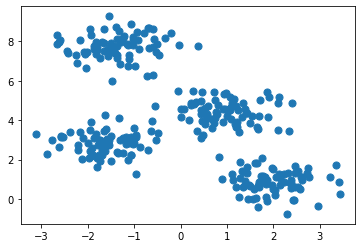

In [4]:
X, _ = make_blobs(
    n_samples=300,
    centers=4,
    cluster_std=.6,
    random_state=RANDOM_SEED,
)

plt.scatter(X[:, 0], X[:, 1], s=50)

### Task 1a

Cluster the above data using the K-Means implementation provided by scikit-learn.
Refer to the official documentation: <https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html>

* create an instance of the class `sklearn.cluster.KMeans`
* choose a suitable value for the `n_clusters` parameter
* call the `.fit` method to compute the clustering
* call the `.predict` method to get cluster labels for each data point

In [5]:
from sklearn.cluster import KMeans

In [27]:
kmeans = KMeans(n_clusters=4).fit(X)
cluster_assignment = kmeans.predict(X)
# kmeans.cluster_centers_

### Task 1b

Visualize the resulting clustering.

* use the `plt.scatter` function (see: <https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html>)
* set the color parameter `c` to the cluster labels you computed above

* Optional: also plot the cluster centers (hint: call `plt.scatter` a second time, the cluster centers are stored in the `.cluster_centers_` member of the `KMeans` object)

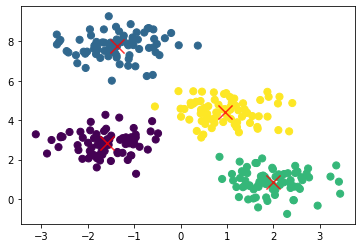

In [28]:
plt.scatter(X[:, 0], X[:, 1], c=cluster_assignment, s=50, cmap="viridis")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="red", marker='x', s=200, alpha=.8)

### Task 1c

Try different numbers of clusters and print the average silhouette scores using
`sklearn.metrics.silhouette_score`. Refer to the documentation: <https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score>

* What does the silhouette score tell you?
* What conclusions do you draw from the numbers?


In [14]:
from sklearn.metrics import silhouette_score

In [29]:
s_score = silhouette_score(X, kmeans.labels_)
print(s_score)

0.6819938690643478


## 📢 **HAND-IN** 📢: Report in Moodle whether you solved this task.

# TASK 2 (2 Points): DBSCAN

First, let's setup the data used in this section. We will redefine the variable `X` containing the data to be clustered.

In [30]:
from sklearn.datasets import make_moons

In [31]:
X, _ = make_moons(
    n_samples=200,
    noise=.05,
    random_state=RANDOM_SEED,
)

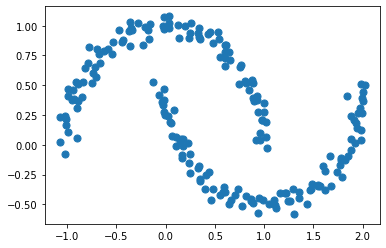

In [32]:
plt.scatter(X[:, 0], X[:, 1], s=50)

### Task 2a

* cluster the new data `X` using `KMeans`
* set `n_clusters=2`
* visualize and analyse the resulting clustering
* What do you think of the result? Did something go wrong?

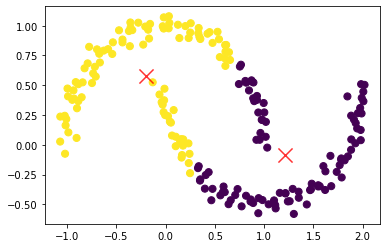

In [33]:
kmeans = KMeans(n_clusters=2).fit(X)
cluster_assignment = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=cluster_assignment, s=50, cmap="viridis")
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="red", marker='x', s=200, alpha=.8)

### Task 2b

Let's use `sklearn.cluster.DBSCAN` instead. Refer to the documentation: <https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html>

* cluster the data using `DBSCAN`
* try different values for `eps` and `min_samples` until you can cluster the two half-moons

In [34]:
from sklearn.cluster import DBSCAN

In [61]:
dbscan = DBSCAN(eps=.3, min_samples=2).fit(X)

In [63]:
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)


def plotDbScan():
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )
    plt.title("Estimated number of clusters: %d" % n_clusters_)
    plt.show()

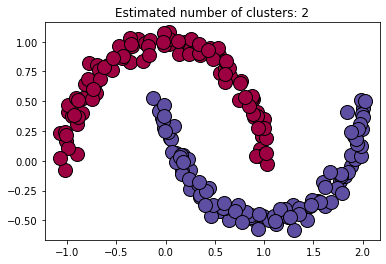

In [64]:
plotDbScan()

## 📢 **HAND-IN** 📢: Report in Moodle whether you solved this task.

# Task 3 (6 Points): Color Clustering in Images

In class you have seen how we can use K-Means for image compression. In this task we ask you to apply this compression technique to an image.

We provide some useful helper functions below. Read the comments in the code carefully, but do not worry if you don't understand it all.


In [ ]:
from PIL import Image
import requests
from io import BytesIO

In [ ]:
def download_img(url: str) -> Image:
  """
  This function fetches an image from the internet and returns a PIL.Image object
  see: https://pillow.readthedocs.io/en/stable/reference/Image.html

  we tested it mainly on images from wikimedia
  """

  # have to set a fake user-agent so we dont get blocked by wikimedia
  headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36'}
  r = requests.get(url, headers=headers)
  if r.status_code != 200:
    # if you hit this exception, consider using another image
    raise Exception(f"download failed:\n{url}")
  
  return Image.open(BytesIO(r.content)).convert("RGB")

def img2arr(img: Image) -> np.array:
  """
  convert a PIL.Image object to a numpy array
  the resulting array has 3 dimensions [height, width, 3]
  the last dimension contains rgb values

  the rgb values are normalized to be between 0. and 1.
  """
  return np.asarray(img) / 255

def arr2img(arr: np.array) -> Image:
  """
  convert a numpy array back into a PIL.Image object
  we expect the rgb values of the array to be between 0. and 1.
  """
  return Image.fromarray((arr * 255).astype(np.int8), mode="RGB")

In [ ]:
img_url = "https://upload.wikimedia.org/wikipedia/commons/d/d7/RGB_24bits_palette_sample_image.jpg"

img = download_img(img_url)

# you can visualize a PIL.Image object directly in jupyter using `display`
display(img)

img_arr = img2arr(img)

# visualize the np.array version of the same image
plt.imshow(img_arr)

In [ ]:
from typing import Optional

def rg_chromaticity(color_arr: np.array) ->  np.array:
  """
  helper function
  """
  sums = np.sum(color_arr, axis=1, keepdims=True)
  normed = np.divide(color_arr, sums, where=sums > 0.)
  return normed

def rg_chroma_plot(img_arr: np.array, centers: Optional[np.array] = None):
  """
  plot an image in rg-chromaticity space
  this is a 2D representation of 3D rgb data
  refer to wikipedia for details: https://en.wikipedia.org/wiki/Rg_chromaticity

  Note: the resulting plot will not accurately reflect the original euclidean distances

  inputs:
  img_arr: a numpy array with 3 dimensions [height, width, 3] representing an image
  centers: a numpy array with 2 dimensions [n_centers, 3] representing the cluster centers 
  """
  colors = np.copy(img_arr).reshape((-1, 3))
  colors = np.unique(colors, axis=0)
  img_rg = rg_chromaticity(colors)
  plt.scatter(img_rg[:, 0], img_rg[:, 1], c=[tuple(colors[i]) for i in range(colors.shape[0])], s=.1)

  if centers is not None:
    crg = rg_chromaticity(centers)
    plt.scatter(crg[:, 0], crg[:, 1], c="black", marker="x", s=25.)

  plt.xlabel("red")
  plt.ylabel("green")
  plt.show()


In [ ]:
rg_chroma_plot(img_arr)

In [ ]:
from sklearn.metrics import pairwise_distances_argmin

def replace_nearest_color(img_arr: np.array, centers: np.array):
  """
  replace each pixel color in `img_arr` by the closest color in `centers`

  input:
  img_arr: a numpy array with 3 dimensions [height, width, 3] representing an image
  centers: a numpy array with 2 dimensions [n_centers, 3] representing the cluster centers 
  """
  colors = img_arr.reshape((-1, 3))
  labels = pairwise_distances_argmin(colors, centers)
  compressed = labels.reshape(img_arr.shape[:2])
  replaced = centers[compressed]
  return replaced


In [ ]:
# generate 8 random colors for illustration
random_centers = np.random.default_rng(RANDOM_SEED).random(size=(8, 3))

# plot the random centers on top of the colors of the image
rg_chroma_plot(img_arr, random_centers)

# replace original colors by their nearest neighbors out of the candidate centers
replaced = replace_nearest_color(img_arr, random_centers)

# convert to PIL.Image and visualize
display(arr2img(replaced))

### Task 3 (continued)

* use an image from [wikimedia](https://commons.wikimedia.org/wiki/Main_Page) to compress. Make sure that it is not too big, e.g. less than 1000px per side

* you can also use the image we used in the example above

* download the image and convert it to a numpy array using `download_img` and `img2arr`  

* cluster the colors in the image using `KMeans` 

* choose the appropriate parameters and verify them (e.g. using `silhouette_score` or the elbow method)

* visualize your final cluster centers using `rg_chroma_plot` (see example usage above)

* replace the colors of the original image by their nearest center using `replace_nearest_color` and display the result (see example usage above)

### Tips

* you will run into problems with array shapes, as the images have 3 dimensions but the clustering algorithms expect 2. You can use [np.reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) to manipulate array dimensions.
* To download the images you can right-click and save them to your computer.

## 📢 **HAND-IN** 📢: A PDF document describing your solution: 

The PDF should contain

* the original image you used for this task

* the final image showing the replaced colors

* your code for computing the clustering

* short (2-3 sentences) description how you verified the clustering 
